In [2]:
import torch
import ot
import numpy as np
import matplotlib.pylab as pl
import math
import scipy

In [3]:
from sampling import svgd,nsvgd,mmd_lbfgs,ksdd_lbfgs

In [4]:
def W_Gauss_empiric(xs,xt):
    a,A=Cov_mean(xs)
    #print(A)
    b,B=Cov_mean(xt)
    #print(B)
    return W_Gauss(a,b,A,B)

def Cov_mean(x): #Compute the mean and covariance for Gaussian approximation
    a=np.mean(x,axis=0)
    A=np.cov((x-a).T)
    return a,A

def W_Gauss(a,b,A,B): #Compute the Wasserstein distance between Gaussian
    A_sq=scipy.linalg.sqrtm(A)
    Bures=np.trace(A+B-2*scipy.linalg.sqrtm(A_sq@B@A_sq)) #is np.real a good idea?
    return Bures+np.linalg.norm(a-b)**2

def coefflog_approx(x,y):
    x=np.array([math.log10(s) for s in x])
    y=np.array([math.log10(s) for s in y])
    A = np.vstack([x, np.ones(x.shape[0])]).T
    y = y[:, np.newaxis]
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha[0]

In [5]:
n,d=100,2

score = lambda x: x  
mu = np.zeros(d)
cov = np.ones(d)
cov = np.diag(cov)
cov = cov* np.eye(d)

In [6]:
#iid
x_iid = np.random.multivariate_normal(mu, cov, n)

In [7]:
# MMD (need sample)
sample = np.random.multivariate_normal(mu, cov, 20*n)
x_mmd_g=mmd_lbfgs(torch.rand(n, d), torch.tensor(x_iid), bw=1, max_iter=10000, tol=1e-5,
              store=False)

In [8]:
# Kernel Stein Discrepency ~ MMD with score
x_ksd = ksdd_lbfgs(torch.rand(n, d), score, kernel='gaussian', bw=1.,
               max_iter=10000, tol=1e-15, beta=.5,
               store=False, verbose=False)

In [9]:
# Stein Variational Gradient Descent ~ ?
#x_svgd=svgd(torch.rand(n, d), score, step=7e-2,kernel='Laplace', max_iter=100, bw=-1, tol=1e-10,ada=False)
x_svgd=svgd(torch.tensor(x_iid), score, step=7e-2,kernel='Laplace', max_iter=100, bw=-1, tol=1e-10,ada=False)

#x_nsvgd=nsvgd(torch.rand(n, d), score,step=2e-4,kernel='Laplace', max_iter=500, bw=-1, tol=1e-10,alpha=.9,h=1, ada=False)
#x_nsvgd=nsvgd(torch.tensor(x_iid), score,step=2e-4,kernel='Laplace', max_iter=100, bw=-1, tol=1e-10,alpha=.9,h=1, ada=False)
#x_svgd[:5,:5],x_nsvgd[:5,:5]

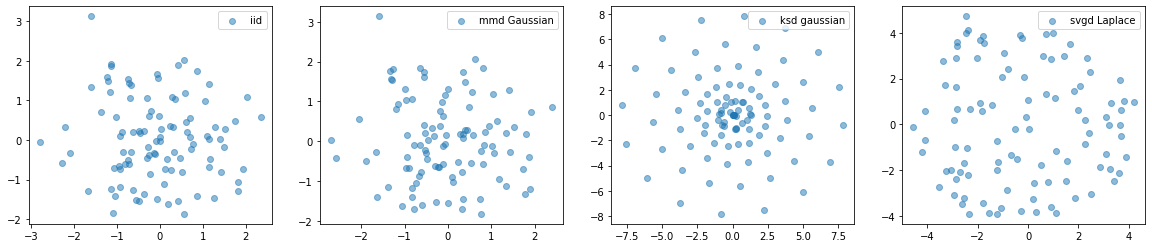

In [10]:
pl.figure(figsize=(20,4))
pl.subplot(1,4,1)
pl.scatter(x_iid[:, 0], x_iid[:, 1],alpha=0.5,label='iid')
pl.legend()

pl.subplot(1,4,2)
pl.scatter(x_mmd_g[:, 0], x_mmd_g[:, 1],alpha=0.5,label='mmd Gaussian')
pl.legend()

pl.subplot(1,4,3)
pl.scatter(x_ksd[:, 0], x_ksd[:, 1],alpha=0.5,label='ksd gaussian')
pl.legend()

pl.subplot(1,4,4)
pl.scatter(x_svgd[:, 0], x_svgd[:, 1],alpha=0.5,label='svgd Laplace')
pl.legend()

# Sample Complexity pour un sampling iid

In [18]:
n_seed=10 #nb of repetition of the experience

max_n=3.3
nb_n=20
n_l= np.logspace(1.5, max_n, nb_n, dtype=int)
print('nb point',n_l)

nb_dim=10
max_dim=2.3#10^
dim_l = np.logspace(.4, max_dim, nb_dim, dtype=int)
print('dim',dim_l)

res_iid=np.zeros((n_seed,len(dim_l),len(n_l)))

nb point [  31   39   48   60   75   94  117  145  181  225  280  348  433  538
  670  833 1037 1289 1604 1995]
dim [  2   4   6  10  17  28  46  75 122 199]


In [19]:
for s in range(n_seed):
    print('seed #',s,': ',end=' ')
    for i,d in enumerate(dim_l):
        print(i,end=' ')
        mu = np.zeros(d)
        cov = np.ones(d)
        cov = np.diag(cov)
        cov = cov* np.eye(d)
        for j,n in enumerate(n_l):
            x_iid = np.random.multivariate_normal(mu, cov, n)
            y_iid = np.random.multivariate_normal(mu, cov, n)
            res_iid[s,i,j]=ot.emd2([],[],ot.dist(x_iid,y_iid))
    print()

seed # 0 :  0 1 2 3 4 5 6 7 8 9 
seed # 1 :  0 1 2 3 4 5 6 7 8 9 
seed # 2 :  0 1 2 3 4 5 6 7 8 9 
seed # 3 :  0 1 2 3 4 5 6 7 8 9 
seed # 4 :  0 1 2 3 4 5 6 7 8 9 
seed # 5 :  0 1 2 3 4 5 6 7 8 9 
seed # 6 :  0 1 2 3 4 5 6 7 8 9 
seed # 7 :  0 1 2 3 4 5 6 7 8 9 
seed # 8 :  0 1 2 3 4 5 6 7 8 9 
seed # 9 :  0 1 2 3 4 5 6 7 8 9 


In [20]:
res_iid_mean=np.mean(res_iid,axis=0)
res_iid_std = np.std(res_iid, axis=0)

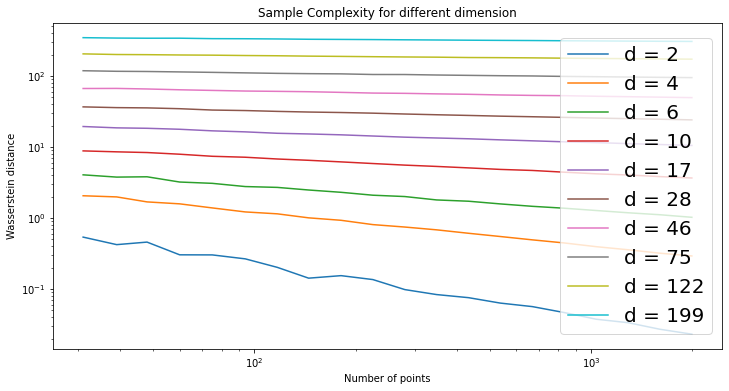

In [21]:
pl.figure(figsize=(12,6))
for i in range(len(dim_l)):
    pl.plot(n_l, res_iid_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.show()

In [22]:
coeff_W=np.array([coefflog_approx(n_l,res_iid_mean[i,:])[0] for i in range(nb_dim)])

print("Empirically",coeff_W)
print("Theoretically",-2/dim_l)
print("Theoretically",-1/dim_l)

Empirically [-0.75797936 -0.47639486 -0.33451645 -0.21683874 -0.14795144 -0.10263037
 -0.07369427 -0.05341285 -0.03980369 -0.02901193]
Theoretically [-1.         -0.5        -0.33333333 -0.2        -0.11764706 -0.07142857
 -0.04347826 -0.02666667 -0.01639344 -0.01005025]
Theoretically [-0.5        -0.25       -0.16666667 -0.1        -0.05882353 -0.03571429
 -0.02173913 -0.01333333 -0.00819672 -0.00502513]


# Sample Complexity pour un sampling MMD

In [23]:
n_seed=10 #nb of repetition of the experience

max_n=3.3
nb_n=20
n_l= np.logspace(1.5, max_n, nb_n, dtype=int)
print('nb point',n_l)

nb_dim=10
max_dim=2.3#10^
dim_l = np.logspace(.4, max_dim, nb_dim, dtype=int)
print('dim',dim_l)

res_mmd=np.zeros((n_seed,len(dim_l),len(n_l)))
res_mmd_B1=np.zeros((n_seed,len(dim_l),len(n_l)))
res_mmd_B2=np.zeros((n_seed,len(dim_l),len(n_l)))

nb point [  31   39   48   60   75   94  117  145  181  225  280  348  433  538
  670  833 1037 1289 1604 1995]
dim [  2   4   6  10  17  28  46  75 122 199]


In [ ]:
for s in range(n_seed):
    print('seed #',s,': ',end=' ')
    for i,d in enumerate(dim_l):
        print(i,end=' ')
        mu1 = np.zeros(d)
        mu2 = np.zeros(d)
        cov1 = np.diag(np.random.randint(low=1,high=5, size=d))
        cov2 = np.diag(np.random.randint(low=1,high=5, size=d))
        mu=np.zeros(d)
        cov = np.eye(d)
        for j,n in enumerate(n_l):
            sample1 = np.random.multivariate_normal(mu1, cov1, n)
            sample2 = np.random.multivariate_normal(mu2, cov2, n)
            gauss = np.random.multivariate_normal(mu, cov, n)
            
            x_mmd=mmd_lbfgs(torch.tensor(sample1), torch.tensor(sample1), bw=1, max_iter=10000, tol=1e-7,
              store=False).numpy()
            y_mmd=mmd_lbfgs(torch.tensor(sample2), torch.tensor(sample2), bw=1, max_iter=10000, tol=1e-7,
              store=False).numpy()
            
            res_mmd[s,i,j]=abs(ot.emd2([],[],ot.dist(x_mmd,y_mmd)))
            res_mmd_B1[s,i,j]=W_Gauss_empiric(gauss,x_mmd)
            res_mmd_B2[s,i,j]=W_Gauss_empiric(gauss,y_mmd)
    print()

seed # 0 :  0 1 2 3 4 5 6 

/tmp/ipykernel_12384/465199670.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  res_mmd_B1[s,i,j]=W_Gauss_empiric(gauss,x_mmd)
/tmp/ipykernel_12384/465199670.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  res_mmd_B2[s,i,j]=W_Gauss_empiric(gauss,y_mmd)


7 8 9 

In [ ]:
np.savetxt("result/res_mmd.txt",res_mmd.reshape(res_mmd.shape[0],-1))
np.savetxt("result/res_mmd_B1.txt",res_mmd_B1.reshape(res_mmd.shape[0],-1))
np.savetxt("result/res_mmd_B2.txt",res_mmd_B2.reshape(res_mmd.shape[0],-1))

In [ ]:
res_mmd_mean=np.mean(res_mmd,axis=0)
res_mmd_std = np.std(res_mmd, axis=0)

res_mmd_B1_mean=np.mean(res_mmd_B1,axis=0)
res_mmd_B1_std = np.std(res_mmd_B1, axis=0)
res_mmd_B2_mean=np.mean(res_mmd_B2,axis=0)
res_mmd_B2_std = np.std(res_mmd_B2, axis=0)

In [ ]:
pl.figure(figsize=(24,6))
pl.subplot(1,2,1)
for i in range(len(dim_l)):
    pl.plot(n_l, res_mmd_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.subplot(1,2,2)
for i in range(len(dim_l)):
    pl.plot(n_l, res_mmd_B1_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.show()

In [ ]:
coeff_W=np.array([coefflog_approx(n_l,res_mmd_mean[i,:])[0] for i in range(nb_dim)])

print("Empirically",coeff_W)
print("Theoretically",-2/dim_l)
print("Theoretically",-1/dim_l)

# Sample Complexity pour un sampling KSD

In [ ]:
n_seed=10 #nb of repetition of the experience

max_n=3.3
nb_n=20
n_l= np.logspace(1.5, max_n, nb_n, dtype=int)
print('nb point',n_l)

nb_dim=10
max_dim=2.3#10^
dim_l = np.logspace(.4, max_dim, nb_dim, dtype=int)
print('dim',dim_l)

res_ksd=np.zeros((n_seed,len(dim_l),len(n_l)))
res_ksd_B1=np.zeros((n_seed,len(dim_l),len(n_l)))
res_ksd_B2=np.zeros((n_seed,len(dim_l),len(n_l)))

In [ ]:
for s in range(n_seed):
    print('seed #',s,': ',end=' ')
    for i,d in enumerate(dim_l):
        print(i,end=' ')
        mu1 = np.zeros(d)
        mu2 = np.zeros(d)
        cov1 = np.diag(np.random.randint(low=1,high=5, size=d))
        cov2 = np.diag(np.random.randint(low=1,high=5, size=d))
        mu=np.zeros(d)
        cov = np.eye(d)
        for j,n in enumerate(n_l):
            sample1 = np.random.multivariate_normal(mu1, cov1, n)
            sample2 = np.random.multivariate_normal(mu2, cov2, n)
            gauss = np.random.multivariate_normal(mu, cov, n)
            
            x_ksd = ksdd_lbfgs(torch.tensor(sample1), score, kernel='gaussian', bw=.1,max_iter=10000, tol=1e-15, beta=.5,
               store=False, verbose=False).numpy()
            y_ksd = ksdd_lbfgs(torch.tensor(sample2), score, kernel='gaussian', bw=.1,max_iter=10000, tol=1e-15, beta=.5,
               store=False, verbose=False).numpy()

            res_ksd[s,i,j]=abs(ot.emd2([],[],ot.dist(x_ksd,y_ksd)))
            res_ksd_B1[s,i,j]=W_Gauss_empiric(gauss,x_ksd)
            res_ksd_B2[s,i,j]=W_Gauss_empiric(gauss,y_ksd)
    print()

In [ ]:
np.savetxt("result/res_ksd.txt",res_ksd.reshape(res_ksd.shape[0],-1))
np.savetxt("result/res_ksd_B1.txt",res_ksd_B1.reshape(res_ksd_B1.shape[0],-1))
np.savetxt("result/res_ksd_B2.txt",res_ksd_B2.reshape(res_ksd_B2.shape[0],-1))

In [ ]:
res_ksd_mean=np.mean(res_ksd,axis=0)
res_ksd_std = np.std(res_ksd, axis=0)

res_ksd_B1_mean=np.mean(res_ksd_B1,axis=0)
res_ksd_B1_std = np.std(res_ksd_B1, axis=0)
res_ksd_B2_mean=np.mean(res_ksd_B2,axis=0)
res_ksd_B2_std = np.std(res_ksd_B2, axis=0)

In [ ]:
pl.figure(figsize=(24,6))
pl.subplot(1,2,1)
for i in range(len(dim_l)):
    pl.plot(n_l, res_ksd_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.subplot(1,2,2)
for i in range(len(dim_l)):
    pl.plot(n_l, res_ksd_B1_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.show()

In [ ]:
coeff_W=np.array([coefflog_approx(n_l,res_ksd_mean[i,:])[0] for i in range(nb_dim)])

print("Empirically",coeff_W)
print("Theoretically",-2/dim_l)
print("Theoretically",-1/dim_l)

# Sample Complexity pour un sampling SVGD Laplace

In [ ]:
n_seed=10 #nb of repetition of the experience

max_n=3.3
nb_n=20
n_l= np.logspace(1.5, max_n, nb_n, dtype=int)
print('nb point',n_l)

nb_dim=10
max_dim=2.3#10^
dim_l = np.logspace(.4, max_dim, nb_dim, dtype=int)
print('dim',dim_l)

res_svgd=np.zeros((n_seed,len(dim_l),len(n_l)))
res_svgd_B1=np.zeros((n_seed,len(dim_l),len(n_l)))
res_svgd_B2=np.zeros((n_seed,len(dim_l),len(n_l)))

In [ ]:
for s in range(n_seed):
    print('seed #',s,': ',end=' ')
    for i,d in enumerate(dim_l):
        print(i,end=' ')
        mu1 = np.zeros(d)
        mu2 = np.zeros(d)
        cov1 = np.diag(np.random.randint(low=1,high=5, size=d))
        cov2 = np.diag(np.random.randint(low=1,high=5, size=d))
        mu=np.zeros(d)
        cov = np.eye(d)
        for j,n in enumerate(n_l):
            sample1 = np.random.multivariate_normal(mu1, cov1, n)
            sample2 = np.random.multivariate_normal(mu2, cov2, n)
            gauss = np.random.multivariate_normal(mu, cov, n)
            
            x_svgd=svgd(torch.tensor(sample1), score, step=7e-2,kernel='Laplace', max_iter=500,
                    bw=-1, tol=1e-10,ada=False).numpy()
            sample = np.random.multivariate_normal(mu, cov, n)
            y_svgd=svgd(torch.tensor(sample2), score, step=7e-2,kernel='Laplace', max_iter=500,
                    bw=-1, tol=1e-10,ada=False).numpy()
            
            res_svgd[s,i,j]=abs(ot.emd2([],[],ot.dist(x_svgd,y_svgd)))
            res_svgd_B1[s,i,j]=W_Gauss_empiric(gauss,x_svgd)
            res_svgd_B2[s,i,j]=W_Gauss_empiric(gauss,y_svgd)
    print()

In [ ]:
np.savetxt("result/res_svgd.txt",res_svgd.reshape(res_svgd.shape[0],-1))
np.savetxt("result/res_svgd_B1.txt",res_svgd_B1.reshape(res_svgd_B1.shape[0],-1))
np.savetxt("result/res_svgd_B2.txt",res_svgd_B2.reshape(res_svgd_B2.shape[0],-1))

In [ ]:
res_svgd_mean=np.mean(res_svgd,axis=0)
res_svgd_std = np.std(res_svgd, axis=0)

res_svgd_B1_mean=np.mean(res_svgd_B1,axis=0)
res_svgd_B1_std = np.std(res_svgd_B1, axis=0)
res_svgd_B2_mean=np.mean(res_svgd_B2,axis=0)
res_svgd_B2_std = np.std(res_svgd_B2, axis=0)

In [ ]:
pl.figure(figsize=(24,6))
pl.subplot(1,2,1)
for i in range(len(dim_l)):
    pl.plot(n_l, res_svgd_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.subplot(1,2,2)
for i in range(len(dim_l)):
    pl.plot(n_l, res_svgd_B1_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.show()

In [ ]:
coeff_W=np.array([coefflog_approx(n_l,res_svgd_mean[i,:])[0] for i in range(nb_dim)])

print("Empirically",coeff_W)
print("Theoretically",-2/dim_l)
print("Theoretically",-1/dim_l)